# Starscape marketplace resource demand

in the in-game marketplace for Starscape, a game that's kind of like Eve Online, there's a central marketplace where players can buy and sell items.

In normal economics, there's a concept of "price-demand curve" where, as demand for a thing changes, its price changes accordingly. I wanted to see if this was also reflected in this game's market.

Players can create market orders with the following specifications:
* buy or sell order (offer to buy or sell an item)
* item name
* price
* quanitity


In [79]:
import pandas as pd

In [80]:
import math 

In [81]:
import datetime as datetime

Some mad scientist has created a bot which periodically scans each market order and puts its information into a database.

For example, a row in the database would contain:   
* id: a serial number assigned to each scan (irrelevant)    
* user id: the ID number of the user who placed the order. Each user can only have 1 order for a particular item active at a time.    
* resource: the name of the resouce (in this case, it is "axnit," a that is used in making many items)    
* location: the location the order was placed (irrelevant, as 99% of all activity happens in one place anyway)    
* price: the price that the user is buying/selling the item at    
* date: the year, month, day, minute, and second the scan was taken (UTC)

In [132]:
axnit = pd.read_csv("C:/file_path/axnit_all.csv")

Some shortcomings of this data:

* The bot works with machine vision instead of reading the game data directly
    * This is to prevent the bot from being banned
    * However, it also means the data is not 100% correct
    * The bot maker has told me that the data I am using is correct about 90% of the time
        * Bad data is not removed, leaving us to do it, if neccessary
* It is impossible to tell who fulfills an order
    * This makes it so that we cannot tell between a person cancelling their order or their order being filled
    * *However, we can still see the order status change over time*

To track demand, I am going to look at how fast items get bought at the various price points.

Since it's impossible to directly see how much of any item was sold at any time, it instead has to be inferred by looking at the changes in the quantity of the available sell orders.

# preparing data

so these lines are going to take the lowest price sell order (as an indicator of market price) 
and seperates them into "bestbuyrows"

In [134]:
bestbuyidx = axnit[axnit.type=="sell"].groupby(["dt"]).price.idxmin()

In [135]:
bestbuyrows = axnit.loc[bestbuyidx]

these two lines below are to let me track changes in volume between scans of the listing
if "prevprice" and "prevuserid" are true, then the order in that row must have been the same one as the one before 

why does this matter? if the same order remains the one with the best price between two snapsots,
it means we can look at it to see if its quantity has changed

In [137]:
bestbuyrows["prevprice"] = bestbuyrows.price.shift(1)

In [138]:
bestbuyrows["prevuserid"] = bestbuyrows.user_id.shift(1)

In [139]:
bestbuyrows["issameorder"] = ( bestbuyrows.user_id == bestbuyrows.prevuserid ) & (bestbuyrows.price == bestbuyrows.prevprice)

"changeinqty" is the change in order wty between this order and the last one 
i.e. the amount sold between the two scans

In [141]:
bestbuyrows["changeinqty"] = bestbuyrows.quantity - bestbuyrows.quantity.shift(1)

In [143]:
bestbuyrows['dt'] = pd.to_datetime(bestbuyrows.dt,format="%Y-%m-%d %H:%M:%S")

In [144]:
bestbuyrows["dtdiff"] = (bestbuyrows.dt - bestbuyrows.dt.shift(1)).dt.total_seconds()

In [145]:
bestbuyrows["dtobjects"] = (pd.to_datetime(bestbuyrows.dt))

In [146]:
bestbuyrows["changeindt"] = (bestbuyrows.dtobjects - bestbuyrows.dtobjects.shift(1))

In [248]:
bestbuyrows.head()

,Unnamed: 0,id,material,price,quantity,user_id,location,type,ts,dt,prevprice,prevuserid,issameorder,changeinqty,dtdiff,dtobjects,changeindt,hour,day
2,71218,3804643,Axnit,60,463,4836716,Citadel,sell,2021-06-03 23:43:06,2021-06-03 23:43:06,NaN,NaN,False,NaN,NaN,2021-06-03 23:43:06,NaT,2021-06-03 23:00,2021-06-03
7,71213,3804725,Axnit,60,463,4836716,Citadel,sell,2021-06-03 23:44:16,2021-06-03 23:44:16,60.0,4836716,True,0.0,70.0,2021-06-03 23:44:16,0 days 00:01:10,2021-06-03 23:00,2021-06-03
12,71208,3804837,Axnit,60,463,4836716,Citadel,sell,2021-06-03 23:45:52,2021-06-03 23:45:52,60.0,4836716,True,0.0,96.0,2021-06-03 23:45:52,0 days 00:01:36,2021-06-03 23:00,2021-06-03
17,71203,3804999,Axnit,60,403,4836716,Citadel,sell,2021-06-03 23:48:37,2021-06-03 23:48:37,60.0,4836716,True,-60.0,165.0,2021-06-03 23:48:37,0 days 00:02:45,2021-06-03 23:00,2021-06-03
22,71198,3805148,Axnit,60,403,4836716,Citadel,sell,2021-06-03 23:51:23,2021-06-03 23:51:23,60.0,4836716,True,0.0,166.0,2021-06-03 23:51:23,0 days 00:02:46,2021-06-03 23:00,2021-06-03


In [149]:
bestbuyrows['hour'] = bestbuyrows.dt.dt.to_period("h")

In [150]:
bestbuyrows['day'] = bestbuyrows.dt.dt.to_period("D")

This is the sum of the total amount of the item sold at a certain price point, grouped by day
I will use this to determine how much of this item, "axnit," is soled each day and at which price points

# charting data

In [164]:
def sumVolume(price, range):
    thing1 = bestbuyrows[(bestbuyrows.issameorder) & (bestbuyrows.changeinqty <= 0) & (bestbuyrows.price<price + range) & (bestbuyrows.price >= price)]
    ser = thing1.groupby('day')["changeinqty"].sum()
    ser.name = price
    return ser

In [155]:
import holoviews as hv

In [238]:
df = pd.concat([
    sumVolume(35,5),
    sumVolume(40,5),
    sumVolume(45,5),
    sumVolume(50,5),
    sumVolume(55,5),
    sumVolume(60,5)
], axis=1)

This converts it into the table you see below

In [240]:
concatdf = df.stack().reset_index()

In [249]:
concatdf.columns = ['day','price','totalqty']
concatdf.head()

,day,price,totalqty
0,2021-06-03,60,-300.0
1,2021-06-04,50,-15963.0
2,2021-06-04,55,-5748.0
3,2021-06-04,60,-8185.0
4,2021-06-05,45,-20081.0


In [242]:
concatdf.day = concatdf.day.dt.to_timestamp()

This is an area chart showing how much of each day's "axnit" sales were at one of 6 price points.
You can see that early in the chart, most of the item sold is around the \$50-60 price range.
As time passes, however, the price drops to 40-50. 
Additionally, the total number of items sold seems to have decreased.

The massive spike on 6/28 is due to someone re-listing their massive order at a smaller quantity, tricking us into believing
that 90,000 "axnit" was sold on that day (yet another limitation of the data).

In [243]:
hv.Area.stack(hv.Area(concatdf,kdims=['day'],vdims=['totalqty','price']).groupby('price').overlay()).opts(width=600)

:NdOverlay   [price]
   :Area   [day]   (totalqty,Baseline)

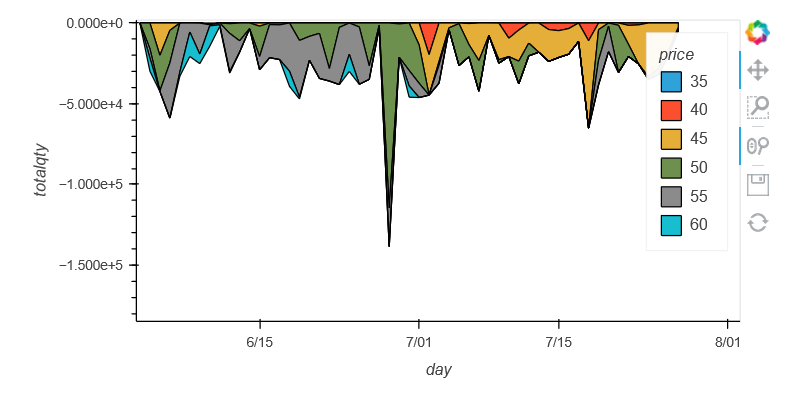

What does this all mean? A few ideas:
1. The price drop is due to decreased demand, not competition
2. The game is dying (Even a price drop does not return the volume sold to its previous level) (becase less people are playing)

# Future work?

* Plotting an actual price-demand curve and seeing how much slope it has
* Market manipulation (buying all of an item and then re-selling it at a profit) is a popular move - is it worth it? Or will the price get driven down too quickly?
* More people play the game on weekends than weekdays - does this have an affect on the market?